In [1]:
%pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [160]:
# from google.colab import userdata
# import os

# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')




In [161]:
!kaggle competitions download -c higgs-boson-detection-2025
!unzip higgs-boson-detection-2025.zip

higgs-boson-detection-2025.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  higgs-boson-detection-2025.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [2]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%cd ICS435/assignment3/

/home/vchan26/ICS435/assignment3


/home/vchan26/.conda/envs/ics435/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import torch
from pytorch_tabnet.tab_model import TabNetClassifier



In [3]:
train = pd.read_csv('train.csv')
X_train = train.drop('label', axis=1)
y_train = train['label']

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, train_size=0.8, random_state=2)
# scaler = StandardScaler()
# X_scaled_train = scaler.fit_transform(X_train)
# X_scaled_val = scaler.transform(X_val)
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(X_scaled_train, y_train)
xgb.set_config(verbosity=1)

test = pd.read_csv('test.csv')

In [5]:
def modelfit(alg, X_train, y_train, X_val, y_val, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    # Perform Cross-Validation to find optimal number of boosting rounds
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    # Train the model
    alg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

    # Predictions
    y_train_pred = alg.predict(X_train)
    y_train_prob = alg.predict_proba(X_train)[:, 1]
    y_val_pred = alg.predict(X_val)
    y_val_prob = alg.predict_proba(X_val)[:, 1]

    # Model Report
    print("\nModel Report")
    print(f"Train Accuracy : {metrics.accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Train AUC : {metrics.roc_auc_score(y_train, y_train_prob):.4f}")
    print(f"Validation Accuracy : {metrics.accuracy_score(y_val, y_val_pred):.4f}")
    print(f"Validation AUC : {metrics.roc_auc_score(y_val, y_val_prob):.4f}")

    # Feature Importance Plot
    feat_imp = pd.Series(alg.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    return alg


In [4]:

params = {'max_depth': 11, 'min_child_weight': 5, 'learning_rate': 0.004466022836585045, 'subsample': 0.703237335080885, 'colsample_bytree': 0.9949901696482174, 'reg_alpha': 7.196356878367213e-07, 'reg_lambda': 0.023281418194967988}
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=2500,
    learning_rate=0.004466022836585045,
    max_depth=11,
    reg_alpha=7.196356878367213e-07,
    min_child_weight=5,
    gamma=0,
    subsample=0.703237335080885,
    colsample_bytree=0.9949901696482174,
    reg_lambda=0.023281418194967988,
    objective= 'binary:logistic',
    tree_method='hist',
    max_bin=256
)

xgb_model.fit(X_train, y_train)
feature_importance = xgb_model.feature_importances_
selected_features = np.array(X_train.columns)[feature_importance > np.percentile(feature_importance, 20)]  # Keep top 50%
X_train_selected = X_train[selected_features]
# X_val_selected = X_val[selected_features]

xgb_model.fit(X_train_selected, y_train)

# alg = modelfit(xgb_model, X_train, y_train, X_val, y_val)
# y_pred_prob = xgb_model.predict_proba(X_val)[:, 1]
# y_pred_prob = xgb_model.predict_proba(X_val_selected)[:, 1]

print(xgb_model.score(X_train_selected, y_train))
# print(xgb_model.score(X_val_selected, y_val))


0.95274


In [5]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),  
        'n_estimators': 5000,
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), 
        'random_state': 42
    }
    
    model = xgb.XGBClassifier(**params, early_stopping_rounds=200)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_prob)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-02-23 01:41:36,551] A new study created in memory with name: no-name-adb5efa6-6dfc-4d83-96ce-c1ca1e7b536c


[I 2025-02-23 01:41:59,781] Trial 0 finished with value: 0.8012398256661752 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.0023077216104406425, 'subsample': 0.5575676364456452, 'colsample_bytree': 0.6217373891514228, 'reg_alpha': 0.0382691866388516, 'reg_lambda': 0.0008010451740826015}. Best is trial 0 with value: 0.8012398256661752.
[I 2025-02-23 01:42:17,279] Trial 1 finished with value: 0.7992607082631773 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.006859199917622361, 'subsample': 0.6197371423213349, 'colsample_bytree': 0.7907951697997665, 'reg_alpha': 1.4962813828245427e-07, 'reg_lambda': 0.10868935826240791}. Best is trial 0 with value: 0.8012398256661752.
[I 2025-02-23 01:42:34,917] Trial 2 finished with value: 0.8037498415834963 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.0056996558897650885, 'subsample': 0.6765697879512005, 'colsample_bytree': 0.6574704354198679, 'reg_alpha': 0.00530960813

Best trial: {'max_depth': 11, 'min_child_weight': 5, 'learning_rate': 0.004466022836585045, 'subsample': 0.703237335080885, 'colsample_bytree': 0.9949901696482174, 'reg_alpha': 7.196356878367213e-07, 'reg_lambda': 0.023281418194967988}


In [6]:

# define the model
clf= TabNetClassifier(
                    optimizer_fn=torch.optim.Adam,
                    scheduler_params={"step_size":10, 
                                        "gamma":0.9},
                    scheduler_fn=torch.optim.lr_scheduler.StepLR,
                    device_name='cuda')

xt = X_train_selected.to_numpy()
yt = y_train.to_numpy()
# xv = X_val_selected.to_numpy()
# yv = y_val.to_numpy()
# fit the model 
clf.fit(
    xt,yt,
    # eval_set=[(xt,yt), (xv, yv)],
    # eval_name=['train', 'test'],
    # eval_metric=['auc','balanced_accuracy'],
    max_epochs=200, patience=60,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
)            

/home/vchan26/.conda/envs/ics435/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/vchan26/.conda/envs/ics435/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69178 |  0:00:03s
epoch 1  | loss: 0.64896 |  0:00:05s
epoch 2  | loss: 0.63479 |  0:00:07s
epoch 3  | loss: 0.61966 |  0:00:08s
epoch 4  | loss: 0.61436 |  0:00:10s
epoch 5  | loss: 0.613   |  0:00:12s
epoch 6  | loss: 0.60961 |  0:00:14s
epoch 7  | loss: 0.60583 |  0:00:16s
epoch 8  | loss: 0.60204 |  0:00:18s
epoch 9  | loss: 0.59676 |  0:00:20s
epoch 10 | loss: 0.60214 |  0:00:22s
epoch 11 | loss: 0.59703 |  0:00:23s
epoch 12 | loss: 0.5915  |  0:00:25s
epoch 13 | loss: 0.59384 |  0:00:27s
epoch 14 | loss: 0.59534 |  0:00:29s
epoch 15 | loss: 0.59505 |  0:00:31s
epoch 16 | loss: 0.59313 |  0:00:33s
epoch 17 | loss: 0.59086 |  0:00:35s
epoch 18 | loss: 0.58794 |  0:00:37s
epoch 19 | loss: 0.58655 |  0:00:39s
epoch 20 | loss: 0.58473 |  0:00:41s
epoch 21 | loss: 0.58143 |  0:00:43s
epoch 22 | loss: 0.5762  |  0:00:45s
epoch 23 | loss: 0.5776  |  0:00:47s
epoch 24 | loss: 0.57476 |  0:00:49s
epoch 25 | loss: 0.57133 |  0:00:51s
epoch 26 | loss: 0.57596 |  0:00:52s
e

In [38]:
xv = X_val[selected_features].to_numpy()
y_pred_prob2 = clf.predict_proba(xv)[:, 1]

0.8092411988969033


Text(0, 0.5, 'True Positive Rate')

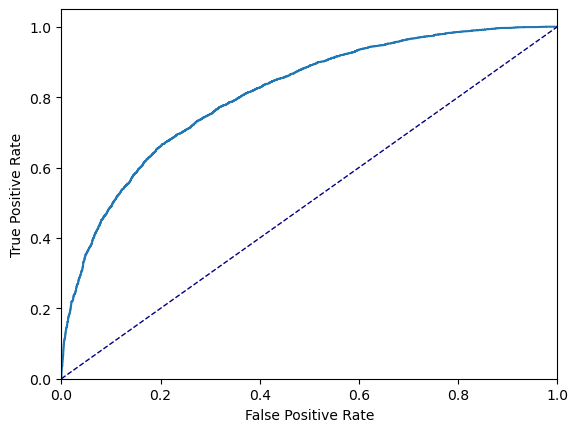

In [44]:
averaged_probabilities = (y_pred_prob * 0.9 + y_pred_prob2 * 0.1)


fpr, tpr, thresholds = metrics.roc_curve(y_val, averaged_probabilities, pos_label=1)
print(metrics.auc(fpr, tpr))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


In [7]:
test = test[selected_features]
predictions = (xgb_model.predict_proba(test)[:, 1] * 0.9 + clf.predict_proba(test.to_numpy())[:,1] * 0.1)
# predictions = xgb_model.predict_proba(test)[:,1]
print(predictions)
ids = np.arange(len(predictions))
submission = np.column_stack((ids, predictions))
np.savetxt(fname='sumbision.csv', X=submission, header='Id,Predicted', delimiter=',', comments='')


[0.057201   0.34034422 0.7326622  ... 0.9386443  0.14421473 0.10549067]
